In [4]:
import os
import cv2
import tensorflow as tf
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataset import modify_mask
import requests, io
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from dataset import create_dataset, map_function
import pathlib

In [5]:
# Recreate the exact same model, including its weights and the optimizer
basedir = os.getcwd()
model_path = os.path.join(basedir, 'result', 'tf_full.h5')
history_path = os.path.join(basedir, 'result', 'history.csv')
with tf.device('/cpu:0'):
    unet_model = tf.keras.models.load_model(model_path, custom_objects={"iou_score": sm.metrics.iou_score})

In [13]:
basedir = os.getcwd()
dpath = os.path.join(basedir, "input/")
df = pd.read_csv(dpath + 'metadata.csv')
df['Image'] = df['Image'].map(lambda x: dpath + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: dpath + 'Mask/' + x)
df_train, df_test = train_test_split(df, test_size=0.1)

def representative_data_gen():
    img_size, bs, num = 64, 1, 10
    training = True
    dataset = tf.data.Dataset.from_tensor_slices((df_train['Image'], df_train['Mask']))
    dataset = dataset.map(lambda img, mask: tf.numpy_function(
        map_function, [img, mask, (img_size, img_size), training], [tf.float32, tf.float32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(bs)

    for input_img, input_mask in dataset.take(num):
        yield [input_img]

def get_default_tflite_model(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    return tflite_model

def get_quantized_tflite_model(model, repr_data, quant_type):
    converter = tf.lite.TFLiteConverter.from_keras_model(unet_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = repr_data

    if quant_type == 'int':
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif quant_type == 'float':
        converter.target_spec.supported_types = [tf.float16]

    tflite_model_quant = converter.convert()

    return tflite_model_quant

tflite_models_dir = pathlib.Path(os.path.join(basedir, "tflite_models"))
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model = get_default_tflite_model(unet_model)
tflite_model_file = tflite_models_dir/"unet.tflite"
tflite_model_file.write_bytes(tflite_model)

tflite_model_float = get_quantized_tflite_model(unet_model, representative_data_gen, quant_type='float')
tflite_model_float_file = tflite_models_dir/"unet_fp16.tflite"
tflite_model_float_file.write_bytes(tflite_model_float)

tflite_model_int = get_quantized_tflite_model(unet_model, representative_data_gen, quant_type='int')
tflite_model_int_file = tflite_models_dir/"unet_int8.tflite"
tflite_model_int_file.write_bytes(tflite_model_int)

2023-06-03 14:46:58.116935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-06-03 14:46:58.187725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-06-03 14:46:58.260850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-06-03

INFO:tensorflow:Assets written to: /tmp/tmpohpfxz2s/assets


INFO:tensorflow:Assets written to: /tmp/tmpohpfxz2s/assets
2023-06-03 14:47:22.776768: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-03 14:47:22.776821: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-03 14:47:22.777060: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpohpfxz2s
2023-06-03 14:47:22.804272: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-03 14:47:22.804307: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpohpfxz2s
2023-06-03 14:47:22.930250: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-03 14:47:23.988792: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpohpfxz2s
2023-06-03 14:47:24.253297: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd46ttai4/assets


INFO:tensorflow:Assets written to: /tmp/tmpd46ttai4/assets
2023-06-03 14:47:52.260623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-03 14:47:52.260679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-03 14:47:52.260872: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd46ttai4
2023-06-03 14:47:52.286665: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-03 14:47:52.286699: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd46ttai4
2023-06-03 14:47:52.406861: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-03 14:47:53.479244: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpd46ttai4
2023-06-03 14:47:53.758127: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmdf_hnfy/assets


INFO:tensorflow:Assets written to: /tmp/tmpmdf_hnfy/assets
/home/tuttelikz/miniconda3/envs/tfseg-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-03 14:48:26.442772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-03 14:48:26.442835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-03 14:48:26.443029: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmdf_hnfy
2023-06-03 14:48:26.472729: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-03 14:48:26.472766: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmdf_hnfy
2023-06-03 14:48:26.601822: I tensorflow/cc/

8524856

In [23]:
def get_file_sizes(model_file):
    print("model in Mb:", os.path.getsize(model_file) / float(2**20))

def get_io_types(model_file):
    interpreter = tf.lite.Interpreter(model_content=model_file)
    input_type = interpreter.get_input_details()[0]['dtype']
    output_type = interpreter.get_output_details()[0]['dtype']
    print(f'input: {input_type} output: {output_type}')

get_io_types(tflite_model)
get_file_sizes(tflite_model_file)

get_io_types(tflite_model_float)
get_file_sizes(tflite_model_float_file)

get_io_types(tflite_model_int)
get_file_sizes(tflite_model_int_file)

input: <class 'numpy.float32'> output: <class 'numpy.float32'>
model in Mb: 30.52822494506836
input: <class 'numpy.float32'> output: <class 'numpy.float32'>
model in Mb: 15.29947280883789
input: <class 'numpy.uint8'> output: <class 'numpy.uint8'>
model in Mb: 8.129936218261719


In [28]:
def get_test_image():
    url = 'https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'
    IMG_SIZE = (64, 64)

    response = requests.get(url)
    bytes_im = io.BytesIO(response.content)
    img = np.array(Image.open(bytes_im))[:, :, :3]

    img = img/255.0
    img = cv2.resize(img, IMG_SIZE)
    # img = np.expand_dims(img, axis = 0)
    return img


def run_tflite_model(test_image, tflite_file):
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
        print("entered quant")
        input_scale, input_zero_point = input_details["quantization"]
        test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(
        test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    return output

test_image = get_test_image()
output = run_tflite_model(test_image, tflite_model_file)

(-0.5, 63.5, 63.5, -0.5)

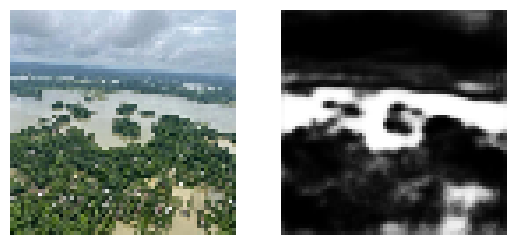

In [29]:
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(output, cmap='gray')
plt.axis('off')